In [ ]:
import os
def find_all_mat_files_in_order(root_dir):   
    mat_files = []
    for dirpath, _, filenames in sorted(os.walk(root_dir)):
        for file in filenames:
            if file.endswith('.mat'):
                mat_files.append(os.path.join(dirpath, file))
    return mat_files

In [ ]:
import math

def load_torque_to_hp(torque_nm, rpm):
    power_watts = (2 * math.pi * torque_nm * rpm) / 60
    power_hp = power_watts / 745.7
    return power_hp


In [ ]:
def specific_info(base_info):
    info_mapping = {
        'KI04': {'extent_damage': 1, 'damage_method': 'LFT', 'manufacturer':'MTK'},
        'KI05': {'extent_damage': 1, 'damage_method': 'ENG', 'manufacturer':'IBU'},
        'KI07': {'extent_damage': 2, 'damage_method': 'ENG', 'manufacturer':'IBU'},
        'KI08': {'extent_damage': 2, 'damage_method': 'ENG', 'manufacturer':'IBU'},
        'KI14': {'extent_damage': 1, 'damage_method': 'LFT', 'manufacturer':'MTK'},
        'KI16': {'extent_damage': 3, 'damage_method': 'LFT', 'manufacturer':'FAG'},
        'KI17': {'extent_damage': 1, 'damage_method': 'LFT', 'manufacturer':'MTK'},
        'KI18': {'extent_damage': 2, 'damage_method': 'LFT', 'manufacturer':'MTK'},
        'KI21': {'extent_damage': 1, 'damage_method': 'LFT', 'manufacturer':'FAG'},
    }
    return info_mapping[base_info]

specific_info('KI04')

<ul>
<li>ENG - Electric Engraver
<li>EDM - Electrical Discharge Machining
<li>DRL - Drilled
<li>LFT - Lifetime Test
</ul>

<p>The KA08 bearing data were not used, because part of the data from one of the working condition is corrupted.</p>


In [ ]:
import os
import re

dir = 'data/raw/paderborn/KI21'

list_files = find_all_mat_files_in_order(dir)
for file in list_files:
    base = re.findall(r'_(K[0AI]\d{2})_', file)[0]
    s_info = specific_info(base)
    
    key = re.findall(r'_K[0AI]\d{2}_', file)[0][2]
    dataset_name = 'Paderborn'
    filename = os.path.basename(file).split('.')[0]
    label = {'0':'N', 'I':'I', 'A':'O'}[key]
    sampling_rate = 64000
    rpm = {'09':'900', '15':'1500'}[re.findall(r'N(\d{2})', file)[0]]
    load = {'04':'400', '10':'1000'}[re.findall(r'_F(\d{2})_', file)[0]]
    load_torque = re.findall(r'_M(\d{2})_', file)[0][1]
    hp = round(load_torque_to_hp(int(load_torque)*0.1, int(rpm)), 2)
    extent_damage = s_info['extent_damage'] # verify
    damage_method = s_info['damage_method'] # verify
    bearing_type = 6203
    condition_bearing_health = {'0':'healthy', 'A':'faulty', 'I':'faulty'}[key]
    manufacturer = s_info['manufacturer'] # verify
    print(f'{dataset_name},{filename},{label},{sampling_rate},{rpm},{hp},{load},{extent_damage},{damage_method},{bearing_type},{condition_bearing_health},{manufacturer}')

## Funções responsáveis pelo gerenciador de dados
Funções responsáveis por filtrar os dados no arquivo de metadados """data/annotation_file.csv"""

In [ ]:
import yaml
import csv

def load_filter():
    with open('config/filters_config.yaml', 'r') as file:
        return yaml.safe_load(file)
    
def load_csv(filepath='data/annotation_file.csv'):   
    data = []
    with open(filepath, mode='r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            data.append(row)
    return data

def filter_data(filter_config=None):
    data = load_csv()
    filtered_data = []

    if not filter_config:
        return data
    
    for dataset, config in filter_config.items():
        for item in data:
            matches = all(
                item.get(key) in value and item.get("dataset_name")==dataset if isinstance(value, list) 
                else item.get(key) == value and item.get("dataset_name")==dataset
                for key, value in config.items()
            )
            if matches:
                filtered_data.append(item)
    
    return filtered_data

# carregando o arquivo yaml que contem as configurações do filtro
filter_config = load_filter()

# carregando o arquivo de configuração contendo o filtro
filter_data(filter_config)        

# carregando o filtro em formato de dicionário diretamente.
filter_data({"CWRU": {"label": ["I"]}})

# retornando todos os dados do arquivo de metadados.
len(filter_data()) # tamanho da lista contendo o dicionário de dados

# filtrando os dados pelo nome do dataset
from datasets.cwru import CWRU
dataset_name = str(CWRU())
len(filter_data({dataset_name: {"dataset_name": dataset_name}}))

161

In [1]:
from src.data_processing.dataset_manager import DatasetManager
metainfo = DatasetManager(dataset_name="CWRU").filter_data()
len(metainfo)

161

## Grouper

In [1]:
import os
from scripts.experiments.helper import get_counter, grouper
from src.data_processing.dataset import SpectrogramImageDataset
from src.data_processing.dataset_manager import DatasetManager
from torchvision import transforms

metainfo = DatasetManager(dataset_name="CWRU").filter_data({"bearing_type": "6205"})
transform = transforms.Compose([
        transforms.Resize((224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  std=[0.229, 0.224, 0.225])
    ]) 
class_names = ['N', 'I', 'O', 'B']  # Your dataset class names
dataset = SpectrogramImageDataset('data/spectrograms', metainfo, class_names, transform)

print('Quantidade de arquivos:', get_counter(dataset, feature_mitigation='extent_damage'))

print('Quantidade de espectrogramas no diretório N:', len(os.listdir('data/spectrograms/N'))-1)
print('Quantidade de espectrogramas no diretório I:', len(os.listdir('data/spectrograms/I'))-1)
print('Quantidade de espectrogramas no diretório O:', len(os.listdir('data/spectrograms/O'))-1)
print('Quantidade de espectrogramas no diretório B:', len(os.listdir('data/spectrograms/B'))-1)

print('Quantidade de dados:', len(dataset.samples))

Quantidade de arquivos: {'000': 80, '007': 580, '014': 345, '021': 580, '028': 80}
Quantidade de espectrogramas no diretório N: 80
Quantidade de espectrogramas no diretório I: 385
Quantidade de espectrogramas no diretório O: 800
Quantidade de espectrogramas no diretório B: 400
Quantidade de dados: 1665


In [15]:
def grouper(dataset, feature_mitigation='extent_damage', verbose=False):
    groups=[]
    labels = []
    hash = {}
    counter = get_counter(dataset, feature_mitigation)
    c=0
    res=dataset.samples
    for i in range(len(dataset)):
        res = f'metainfo: {dataset}'
        path = dataset.samples[i][0]
        basename = os.path.basename(path)
        label = path.split('/')[-2]
        bearing_info = metainfo.filter_data({"filename": basename.split('#')[0]})[0]
        feature_value = bearing_info[feature_mitigation]
        # Distribution of reference bearing values.
        if bearing_info["extent_damage"]=='000':
            groups.append(c)
            c = c + 1 if c < len(counter[feature_mitigation])-2 else 0
        else:
            if feature_value not in hash:
                hash[feature_value] = len(hash)
            groups.append(hash[feature_value])
            labels.append(label)
    
    print(res)
    gl = {}
    for g, l in zip(groups, labels):
        if g not in gl:
            gl[g] = []
        gl[g].append(l)
    print(gl)

    if verbose:
        print('Groups:', set(groups))
        print('Couter:', counter)

    return groups

In [16]:
grouper(dataset, verbose=True)

[]
{}
Groups: set()
Couter: {'extent_damage': [], 'labels': []}


[]

Copia e Cola em outro diretório

In [1]:
import shutil

def copy_file(source_path, destination_path):
    
    try:
        shutil.copy(source_path, destination_path)
        print(f"File successfully copied from {source_path} to {destination_path}.")
    except FileNotFoundError:
        print("Source file not found. Please check the path.")
    except PermissionError:
        print("Permission denied. Check if you have access to the directory.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage
source_path = "data/spectrograms/cwru/N/97#0.png"      # Path of the file to be copied
destination_path = "data/spectrograms/cwru_cv/fold1/N/97.png"    # Path of the destination directory

copy_file(source_path, destination_path)


File successfully copied from data/spectrograms/cwru/N/97#0.png to data/spectrograms/cwru_cv/fold1/N/97.png.


In [6]:
import os

def list_files(directory_path, extension=None):
    
    try:
        # List all files in the directory
        files = os.listdir(directory_path)
        
        # Filter files by extension if specified
        if extension:
            files = [file for file in files if file.endswith(extension)]
        
        return files
    except FileNotFoundError:
        print("Directory not found. Please check the path.")
        return []
    except PermissionError:
        print("Permission denied. Check if you have access to the directory.")
        return []
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

# Example usage
directory_path = "data/spectrograms/cwru/N"  # Path of the target directory
extension = ".png"             # Target file extension (optional)

file_list = list_files(directory_path, extension)
print(file_list)


['100#17.png', '99#11.png', '100#16.png', '98#15.png', '97#13.png', '98#17.png', '100#7.png', '100#1.png', '99#8.png', '100#9.png', '98#13.png', '99#15.png', '97#1.png', '100#3.png', '100#13.png', '98#18.png', '99#13.png', '100#15.png', '98#12.png', '97#18.png', '97#14.png', '98#4.png', '98#5.png', '97#4.png', '98#14.png', '100#19.png', '98#0.png', '97#2.png', '97#10.png', '100#4.png', '100#6.png', '99#0.png', '100#11.png', '100#0.png', '99#16.png', '98#9.png', '97#11.png', '99#9.png', '98#6.png', '98#16.png', '99#3.png', '97#7.png', '99#2.png', '97#15.png', '98#11.png', '98#3.png', '99#1.png', '99#6.png', '97#5.png', '100#8.png', '100#12.png', '99#18.png', '99#10.png', '99#5.png', '99#12.png', '99#7.png', '100#5.png', '98#19.png', '100#18.png', '97#3.png', '97#8.png', '100#14.png', '97#0.png', '99#14.png', '97#17.png', '97#16.png', '99#4.png', '97#12.png', '99#17.png', '98#2.png', '97#9.png', '100#2.png', '98#1.png', '98#7.png', '100#10.png', '99#19.png', '97#6.png', '98#10.png', '97#

In [ ]:
from utils import copy_file, list_files
from src.data_processing.dataset_manager import DatasetManager

def extension_fold_mapping(basename):
    return {
    "000": "fold"+str(int(basename)-96),
    "007": "fold1", 
    "014": "fold2", 
    "021": "fold3", 
    "028": "fold4" }

def copy_spectrogram_to_folds():
    metainfo = DatasetManager("CWRU")
    
    root_dir = "data/spectrograms/cwru/"
    for label in ["N", "I", "O", "B"]:
        list_of_files = list_files(root_dir+label, extension=".png")

        # pega o nome base do arquivo
        for file in list_of_files:
            basename = file.split("#")[0]
            # pesquisa no metainfo retornando a linha correspondente a este arquivo
            info = metainfo.filter_data({"filename": basename})[0]
            # verifica qual o extensão da falha e a classe
            extent_damage = info["extent_damage"]
            fold = extension_fold_mapping(basename)[extent_damage]
            # copia o arquivo para a pasta e classe correspondente
            source_path = os.path.join(root_dir, label, file)
            destination_path = os.path.join("data/spectrograms/cwru_cv", fold, label, file)
            copy_file(source_path, destination_path)

copy_spectrogram_to_folds()

[{'dataset_name': 'CWRU', 'filename': '100', 'label': 'N', 'sampling_rate': '12000', 'rpm': '1730', 'hp': '3', 'load': 'no', 'extent_damage': '000', 'damage_method': 'no', 'bearing_type': '6205', 'condition_bearing_health': 'healthy', 'manufacturer': 'manu_cwru'}]


TypeError: list indices must be integers or slices, not str

In [9]:
l = "a"
d = {"000":"a" if l=="a" else "b"}
d["000"]

'a'

## Estratégia de treinamento

Definindo dispositivo de hardware

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
from torchvision import models, transforms

model = models.resnet18(pretrained=True)
model = model.to(device)
print(list(model.named_children()))

data_transform = transforms.Compose([
                                     transforms.Resize(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225]) ])

In [ ]:
import os
import re
from IPython.display import display

dir = 'data/raw/hust'
list_files = find_all_mat_files_in_order(dir)
metainfo = []
for file in list_files:
    dataset_name = 'Hust'
    base = os.path.basename(file)[:-4]
    label = base[0]
    sampling_rate = 15200
    bearing_type = '620'+re.findall(r'[A-Z]{1,2}(\d)', base)[0]
    rpm = 'no'
    hp = int(base[-1]) * 100 / 745.7
    load = 'no'
    extent_damage = 'no'
    damage_method = 'wire-cutting'
    condition_bearing_health = 'healthy' if label == 'N' else 'faulty'
    manufacturer = 'KG Bearing India'

    metainfo.append(f'{dataset_name},{base},{label},{sampling_rate},{rpm},{hp},{load},{extent_damage},{damage_method},{bearing_type},{condition_bearing_health},{manufacturer}')

metainfo

['Hust,IO600,I,15200,no,0.0,no,no,wire-cutting,6206,faulty,KG Bearing India',
 'Hust,IB500,I,15200,no,0.0,no,no,wire-cutting,6205,faulty,KG Bearing India',
 'Hust,IO500,I,15200,no,0.0,no,no,wire-cutting,6205,faulty,KG Bearing India',
 'Hust,IO702,I,15200,no,0.2682043717312592,no,no,wire-cutting,6207,faulty,KG Bearing India',
 'Hust,OB400,O,15200,no,0.0,no,no,wire-cutting,6204,faulty,KG Bearing India',
 'Hust,N802,N,15200,no,0.2682043717312592,no,no,wire-cutting,6208,healthy,KG Bearing India',
 'Hust,N702,N,15200,no,0.2682043717312592,no,no,wire-cutting,6207,healthy,KG Bearing India',
 'Hust,OB702,O,15200,no,0.2682043717312592,no,no,wire-cutting,6207,faulty,KG Bearing India',
 'Hust,B700,B,15200,no,0.0,no,no,wire-cutting,6207,faulty,KG Bearing India',
 'Hust,B702,B,15200,no,0.2682043717312592,no,no,wire-cutting,6207,faulty,KG Bearing India',
 'Hust,I504,I,15200,no,0.5364087434625184,no,no,wire-cutting,6205,faulty,KG Bearing India',
 'Hust,IO602,I,15200,no,0.2682043717312592,no,no,wire-c

In [76]:
result = None
if 'A' in ['AB', 'BC']:
    result = 'true'
else:
    result = 'false'
result

'false'

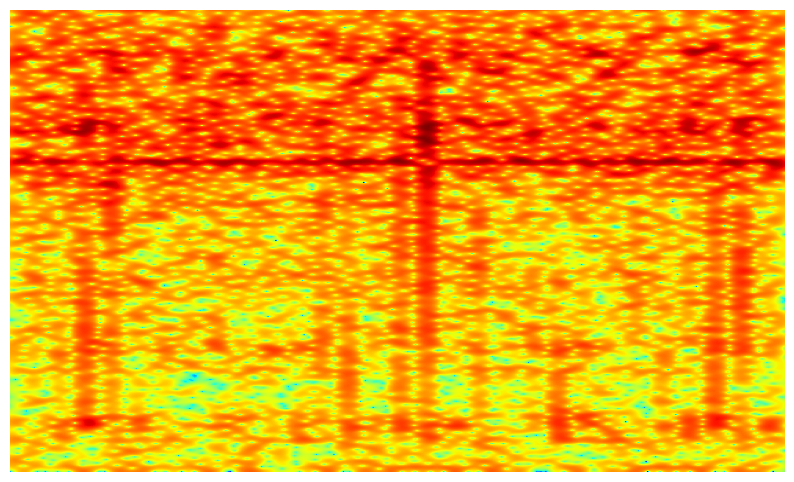

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import scipy.io
from scipy import signal
import pandas as pd

data = scipy.io.loadmat('data/raw/hust/B500.mat')['data'][:, 0]
# data = scipy.io.loadmat('data/raw/cwru/109.mat')['X109_DE_time']

detrended_data = signal.detrend(data)

# Parâmetros específicos para o dataset HUST
fs = int(51.2e3)  # Frequência de amostragem em Hz
signal_length = 12800
sample = detrended_data[:signal_length]  # Comprimento do sinal HUST
window = 'hann'  # Tipo da janela
nperseg = 640    # Comprimento da janela
noverlap = int(nperseg * 0.96)  # 96% de sobreposição
nfft = 1600       # Número de pontos na FFT

# Realizar STFT
frequencies, times, Sxx = signal.stft(
    sample, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, nfft=nfft
)

# Plotar o espectrograma
plt.figure(figsize=(10, 6))
plt.imshow(np.log(np.abs(Sxx[: 382, :]**2)), cmap='jet', aspect='auto')
plt.axis('off')
plt.gca().invert_yaxis()
plt.show()

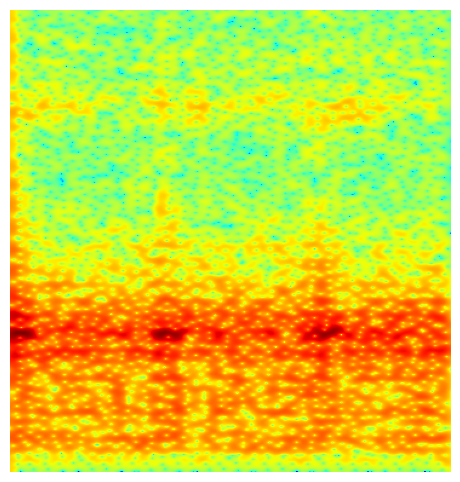

In [111]:
from matplotlib import pyplot as plt
import numpy as np
import scipy.io
from scipy import signal
import pandas as pd

# data = scipy.io.loadmat('data/raw/hust/B500.mat')['data']
data = scipy.io.loadmat('data/raw/uored/B_11_2.mat')['B_11_2'][:, 0]

detrended_data = signal.detrend(data)

fs = int(42e3)  # Sampling frequency in Hz
tend = len(data) / fs

# Perform STFT`
sample = detrended_data[: 10500]
window = 'hann'  # Window type (e.g., 'hann', 'hamming', 'blackman', etc.)
nperseg = 580    # Length of each segment (window length)
noverlap = 551   # Number of points to overlap between segments
nfft = 1600       # Number of points in the FFT
frequencies, times, Zxx = signal.stft(
    sample, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, nfft=nfft)

# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.imshow(np.log(np.abs(Zxx[: 382, :]**2)), cmap='jet')
plt.axis('off')
plt.gca().invert_yaxis()

In [6]:
import yaml

 
with open('config/spectrogram_config.yaml', 'r') as file:
    spectrogram_config = yaml.safe_load(file)

for sck in spectrogram_config.keys():
    print(sck)

CWRU


In [23]:
import csv
from src.data_processing.dataset_manager import DatasetManager
from utils import load_csv, load_yaml

# len(dm)



filter_config = load_yaml('config/filters_config.yaml')["CWRU"]
dm = DatasetManager().filter_data(filter_config)
len(dm)

116

In [ ]:
import torch
from src.models.cnn2d import CNN2D

model = CNN2D()

for name, param in model.named_parameters():
    if name.split(".")[0] in ["conv1", "conv2"]:
        param.requires_grad = False

for name, param in model.named_parameters():   
    print(f"name: {name}, parameter: {len(param)}, requires_grad: {param.requires_grad}")

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)


name: conv1.weight, parameter: 16, requires_grad: False
name: conv1.bias, parameter: 16, requires_grad: False
name: conv2.weight, parameter: 32, requires_grad: False
name: conv2.bias, parameter: 32, requires_grad: False
name: conv3.weight, parameter: 64, requires_grad: True
name: conv3.bias, parameter: 64, requires_grad: True
name: fc1.weight, parameter: 224, requires_grad: True
name: fc1.bias, parameter: 224, requires_grad: True
name: fc2.weight, parameter: 4, requires_grad: True
name: fc2.bias, parameter: 4, requires_grad: True


## Experimentos

Kfold sem mitigação de vieses de similariade

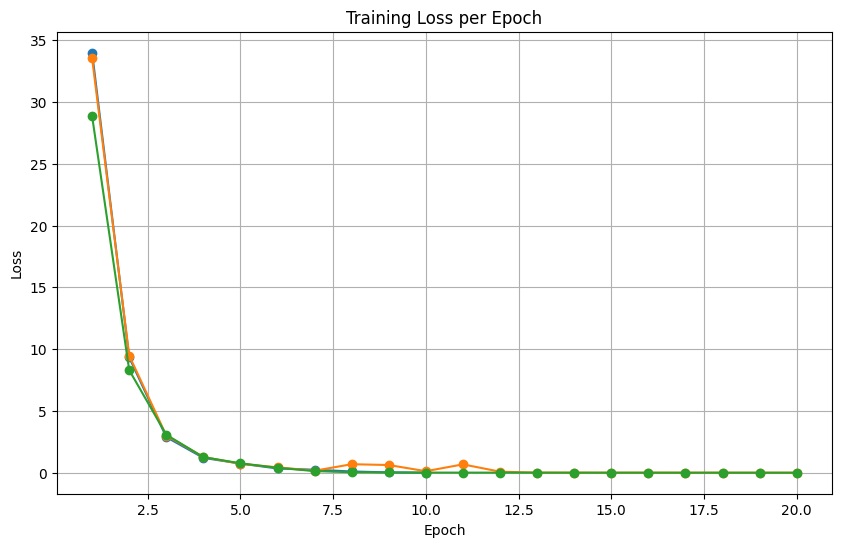

In [18]:
import re
import numpy as np
import matplotlib.pyplot as plt

experiment_path = [
    "results/20241117143315_kfold_no-similarity-bias-mitigation.txt",
    "results/20241117145938_kfold_no-similarity-bias-mitigation.txt",
    "results/20241117150647_kfold_no-similarity-bias-mitigation.txt"
]

def plot_loss(experiment_path):
    plt.figure(figsize=(10,6))
    for path in experiment_path:
        with open(path, "r") as file:
            content = file.read()

        matches = re.findall(r"loss_history=(\[[0-9.,\s]*\])", content)

        loss_history = []
        for match in matches:
            loss_history.append(eval(match))
        mean_loss = np.mean(loss_history, axis=0)


        plt.plot(range(1, len(mean_loss) + 1), mean_loss, marker='o')

    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()

plot_loss(experiment_path)

Kfold Mitigated Similarity Bias by Severity without Pre-Trained Model.

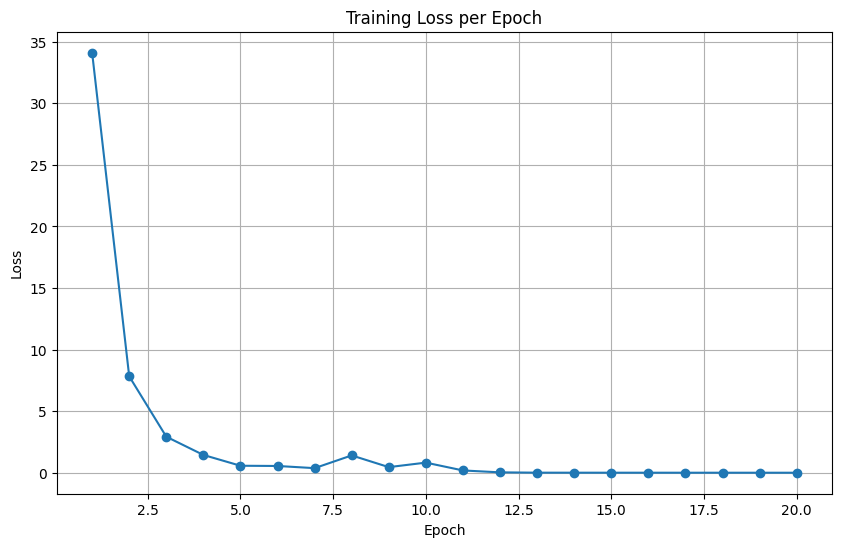

In [19]:
experiment_path = [
    "results/20241117153124_kfold-mitigated-bias-without-pre-trained-model.txt",
]

plot_loss(experiment_path)

Precision

In [9]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

hc = [[ 42,   3, 281, 182],
    [ 19,  36, 225, 213],
    [  0,   0,  80,   0],
    [ 42,  94, 563, 290]]

huc = [[ 16, 184,  50, 258],
 [ 12,  54,  82, 345],
 [  0,   0,  80,   0],
 [ 97, 354,  69, 469]]


def precision(matrix):
    diag_values = np.sum(np.identity(len(matrix)) * np.array(matrix), axis=0)
    sum_column = np.sum(matrix, axis=0)
    print(diag_values / sum_column)

precision(huc)
    

[0.128      0.09121622 0.28469751 0.4375    ]


In [ ]:
import os

len(os.listdir("data/spectrograms/cwru_cv/fold4/B"))

41

In [ ]:
from src.models import CNN2D

model = CNN2D()

for name, params in model.named_parameters():
    print(f"name: {name}, params: {params}")

SyntaxError: invalid syntax (2500260704.py, line 5)